In [16]:
ENV["LD_LIBRARY_PATH"] = ""
using Pkg
using DelimitedFiles
using Distributed
using Distances
using StatsBase 
using Random
using Statistics
using LinearAlgebra
using Distributions
using Plots
using CSV
using DataFrames
using LaTeXStrings

using Measures
using StatsPlots
using Glob

using Printf
rng = Random.MersenneTwister(1234);

#Plots.default(grid =:false, legendfontfamily="Arial", 
#Plots.default(grid =:false, fontfamily="Computer Modern", markeralpha=0.3, legend_background_color=:transparent, 
Plots.default(grid =:false,  markeralpha=0.3, legend_background_color=:transparent, 
labelfontsize=12, tickfontsize=12, legendfontsize=12, markerstrokewidth=0, ms=5,
foreground_color_legend = nothing);
include("../src/figure.jl");

# Fig. 1 -- computational time and memory usage 

In [17]:
n_resample = 30
L_set = [50, 100, 200, 400, 800, 1600]
n_L_max = length(L_set)
B_set, D_set = zeros(n_L_max), zeros(n_L_max)
CT_set, Mem_set = zeros(2, n_L_max), zeros(2, n_L_max)
fkey_CT_Naive = "computational_time_naive-EpisMPL_simple_1.txt"
fkey_CT_Epis = "computational_time_efficient-EpisMPL_simple_1.txt"
#Dt = 30
for i_L in 1:n_L_max
    L = L_set[i_L]
    if(L<=400)
        fname_in = @sprintf("../data/WF/computational_time_naive-EpisMPL_L-%d.txt", L);
        ct_set_naive = readdlm(fname_in)[:,2]
        CT_naive, Mem_naive = ct_set_naive[1], ct_set_naive[3]
        CT_set[1, i_L] = CT_naive
        Mem_set[1, i_L] = Mem_naive
    end            
    
    fname_Eff_in = @sprintf("../data/WF/computational_time_efficient-EpisMPL_L-%d.txt", L) 
    ct_set_eff = readdlm(fname_Eff_in)[:, 2]
    CT_eff, Mem_eff = ct_set_eff[1], ct_set_eff[3]
    CT_set[2, i_L] = CT_eff
    Mem_set[2, i_L] = Mem_eff
end


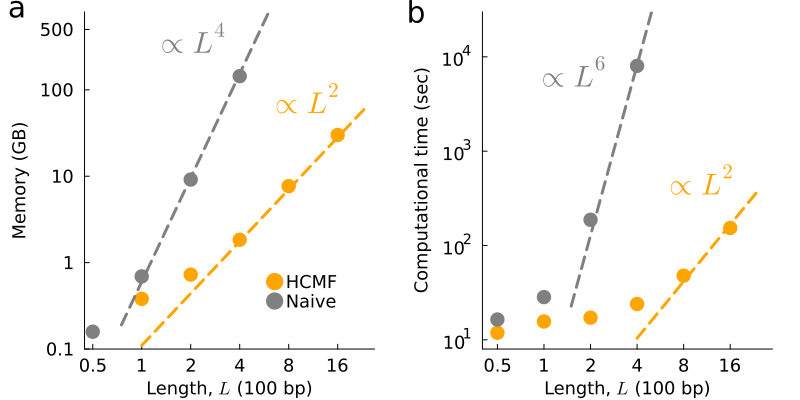

In [18]:
# It looks like the naive resample doesn't exist.
my_ms = 8
ct_cc = copy(CT_set[2, :])
memory_cc = copy(Mem_set[2, :])
yticks_set=[0.1, 1, 10, 100, 500]
yticks_set_str=["0.1", "1", "10", "100", "500"]
my_lw = 3
L_set_str = [@sprintf("%.1f", 0.01*L_set[1]); [@sprintf("%d", 0.01*x) for x in L_set[2:end]] ]

p1 = Plots.plot(xticks=(L_set, L_set_str), yticks = (yticks_set, yticks_set_str), 
    ylabel="Memory (GB)", xlabel=L"Length, $L$ (100 bp)", 
    left_margin=5mm, right_margin=5mm, legend=(0.7, 0.2), yaxis=:log10, xaxis=:log10, ylim=(1e-1, 8e2))
scatter!(p1, L_set, memory_cc, label="HCMF", c=:orange,ms = my_ms, markeralpha=1 )
xvec=[L_set[2:end]; 2.4*10^3]
plot!(p1, xvec, 1.1e-5*xvec .^2 , label=:false, c=:orange, linestyle=:dash, lw=my_lw)
annotate!(1000, 80, text(L"$\propto L^2$", :center, :orange, 20))


scatter!(p1, L_set[1:4], Mem_set[1, 1:4], label="Naive", c=:gray,ms = my_ms, markeralpha=1 )
xvec=[[75];L_set[2:4];[600]]
plot!(p1, xvec, 6e-9*xvec .^4 , label=:false, c=:gray, linestyle=:dash, lw=my_lw)
annotate!(200, 400, text(L"$\propto L^4$", :center, :gray, 20))
annotate!(17, 920, text("a", :center, :black, 20) )

#l = @layout[a{0.45w} _{0.1w} c{0.45w}]

yticks_set=[10, 10^2, 10^3, 10^4]
yticks_set_str=["10^1", "10^2", "10^3", "10^4"]
#yticks_set_str=[10, 10^2, 10^3, 10^4]

p2 = Plots.plot(xticks=(L_set, L_set_str), yticks= (yticks_set), #yticks = (yticks_set, yticks_set_str), 
    ylabel="Computational time (sec)", xlabel=L"Length, $L$ (100 bp)", 
    legend=:false, left_margin=5mm, right_margin=5mm, yaxis=:log10, xaxis=:log10, ylim=(8, 3e4), xlim=(40, 3000))
scatter!(p2, L_set, ct_cc, label="CC", c=:orange, ms = my_ms, markeralpha=1)
xvec=[L_set[4:end]; 2.4*10^3]
plot!(p2, xvec, 6.5e-5*xvec .^2 , label=:false, c=:orange, linestyle=:dash, lw=my_lw)
annotate!(1000, 500, text(L"$\propto L^2$", :center, :orange, 20))

scatter!(p2, L_set[1:4], CT_set[1, 1:4], label="Naive", c=:gray,ms = my_ms, markeralpha=1 )
xvec=[[150]; L_set[3:4]; 5*100]
plot!(p2, xvec, 2e-12*xvec .^6 , label=:false, c=:gray, linestyle=:dash, lw=my_lw)
annotate!(150, 7*10^3, text(L"$\propto L^6$", :center, :gray, 20))
annotate!(15, 3*10^4, text("b", :center, :black, 20) )

p_temp = Plots.plot(p1, p2, layout=(1,2), size=(800, 400), bottom_margin=3mm, );
display(p_temp);
#Plots.savefig("../figures/computational_complexity.pdf")

## Fig. 2 and Fig. 3 -- inferred selection and epistatic coefficients 

In [6]:
df_est_add_tot = CSV.read("../data/WF/selection_summary_L50_long-T.csv", DataFrame)
df_est_tot = CSV.read("../data/WF/epistasis_summary_L50_long-T.csv", DataFrame);

idx_sel_pos, idx_sel_neg, idx_sel_neu = df_est_add_tot.s_true .> 0, df_est_add_tot.s_true .< 0, df_est_add_tot.s_true .== 0;
idx_eps_pos, idx_eps_neg, idx_eps_neu = df_est_tot.s_true .> 0, df_est_tot.s_true .< 0, df_est_tot.s_true .== 0;

### Distribution

In [7]:
# Additive selection with epistasis
my_bins = 60; my_alpha = 0.8; my_lw = 3
y_lim_max, x_lim_max = 0.6, 7
p1_selection_with_E = Plots.plot(xlabel="", ylabel="Frequency", left_margin=3mm, bottom_margin=2mm, 
    title="Full model", legend=(0.15, 0.99), 
    xticks=([-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]), 
    yticks=([0.0, 0.5], [0.0, 0.5]), 
    xlim=(-x_lim_max, x_lim_max),
    ylim=(0, y_lim_max)
)
yvec = (0:0.05:0.4); len_yvec = length(yvec)
plot!(p1_selection_with_E, 100*df_est_add_tot.s_MPL_with_epis[idx_sel_pos], c=:red, label=" Beneficial", 
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
plot!(p1_selection_with_E, 100*df_est_add_tot.s_MPL_with_epis[idx_sel_neg], c=:blue, label=" Deleterious",
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
plot!(p1_selection_with_E, 100*df_est_add_tot.s_MPL_with_epis[idx_sel_neu], c=:gray, label=" Neutral",
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw);
annotate!(-9.5, 0.65, text("a", :center, :black, 20) )
annotate!(0.0, -0.1, text(L"Selection coefficient, $\hat{s}_i$ (%)", :center, :black, 12) )
mean_pos = 100*mean(df_est_add_tot.s_MPL_with_epis[idx_sel_pos])
mean_neu = 100*mean(df_est_add_tot.s_MPL_with_epis[idx_sel_neu])
mean_neg = 100*mean(df_est_add_tot.s_MPL_with_epis[idx_sel_neg])

plot!(p1_selection_with_E, zeros(len_yvec), yvec, linestyle=:dash, c=:gray, label="True")
plot!(p1_selection_with_E, 3*ones(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)
plot!(p1_selection_with_E, -3*ones(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)


p1_selection_without_E = Plots.plot(xlabel="", left_margin=3mm, bottom_margin=2mm, 
    title="Without epistasis", legend=:false,
    xticks=([-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]), 
    yticks=([0.0, 0.5], [0.0, 0.5]), 
    xlim=(-x_lim_max, x_lim_max),
    ylim=(0, y_lim_max)
)
plot!(p1_selection_without_E, zeros(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)
plot!(p1_selection_without_E, 3*ones(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)
plot!(p1_selection_without_E, -3*ones(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)

plot!(p1_selection_without_E, 100*df_est_add_tot.s_MPL_without_epis[idx_sel_pos], c=:pink, label=" Beneficial", 
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
plot!(p1_selection_without_E, 100*df_est_add_tot.s_MPL_without_epis[idx_sel_neg], c=:skyblue, label=" Deleterious",
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
plot!(p1_selection_without_E, 100*df_est_add_tot.s_MPL_without_epis[idx_sel_neu], c=:gray, label=" Neutral",
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
annotate!(-8.5, 0.65, text("b", :center, :black, 20) )
annotate!(0.0, -0.1, text(L"Selection coefficient, $\hat{s}_i$ (%)", :center, :black, 12) )

plot(p1_selection_with_E, p1_selection_without_E, size=(800, 300));

In [8]:

p1_epistasis_MPL = Plots.plot(xlabel=" ", left_margin=3mm, bottom_margin=2mm, 
    title="Full model", 
    legend=(0.15, 0.99), #xlim=(-5, 5), 
    xticks=([-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]), 
    yticks=([0.0, 0.5], [0.0, 0.5]), 
    xlim=(-x_lim_max, x_lim_max),
    ylim=(0, y_lim_max)
)
#yvec = (0:0.1:0.3); len_yvec = length(yvec)
plot!(p1_epistasis_MPL, 100*df_est_tot.s_MPL[idx_eps_pos], ylabel="Frequency", c=:red, label=" Positive", 
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
plot!(p1_epistasis_MPL, 100*df_est_tot.s_MPL[idx_eps_neg], c=:blue, label=" Negative",
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
plot!(p1_epistasis_MPL, 100*df_est_tot.s_MPL[idx_eps_neu], c=:gray, label=" Neutral",
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw);
plot!(p1_epistasis_MPL, zeros(len_yvec), yvec, label="True", linestyle=:dash, c=:gray)
plot!(p1_epistasis_MPL, 3*ones(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)
plot!(p1_epistasis_MPL, -3*ones(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)

annotate!(-9.5, 0.65, text("a", :center, :black, 20) )
annotate!(0.0, -0.1, text(L"Epistatic coefficient $\hat{s}_{ij}$ (%)", :center, :black, 12) )

p1_epistasis_SL = Plots.plot(xlabel=" ",  left_margin=3mm, bottom_margin=2mm, 
    title="Independent model", legend=:false,
    xticks=([-6, -3, 0, 3, 6], [-6, -3, 0, 3, 6]), 
    yticks=([0.0, 0.5], [0.0, 0.5]), 
    xlim=(-x_lim_max, x_lim_max),
    ylim=(0, y_lim_max)
)

#yvec = (0:0.075:0.15); len_yvec = length(yvec)
plot!(p1_epistasis_SL, zeros(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)
plot!(p1_epistasis_SL, 3*ones(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)
plot!(p1_epistasis_SL, -3*ones(len_yvec), yvec, label=:false, linestyle=:dash, c=:gray)

plot!(p1_epistasis_SL, 100*df_est_tot.s_SL[idx_eps_pos], c=:pink, label=" Synergistic", 
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
plot!(p1_epistasis_SL, 100*df_est_tot.s_SL[idx_eps_neg], c=:skyblue, label=" Antagonistic",
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
plot!(p1_epistasis_SL, 100*df_est_tot.s_SL[idx_eps_neu], c=:gray, label=" Neutral",
    normalize=true, seriestype=:stephist, bins=my_bins, alpha=my_alpha, lw=my_lw)
annotate!(-8.5, 0.65, text("b", :center, :black, 20) )
annotate!(0.0, -0.1, text(L"Epistatic coefficient $\hat{s}_{ij}$ (%)", :center, :black, 12) )
#annotate!(3.0, -1, text(L"Epistatic coefficient $s_{ij}$ (%)", :center, :black, 12) )

plot(p1_epistasis_MPL, p1_epistasis_SL, size=(800, 300));

## ROC curves and AUC values

In [9]:
# ============= Beneficial mutation ============ #
# --- Set accumulated TP and FP --- 
idx_sort_add_with_E = sortperm(df_est_add_tot.s_MPL_with_epis, rev=true)
idx_sort_add_without_E = sortperm(df_est_add_tot.s_MPL_without_epis, rev=true)
idx_sort_epis_MPL = sortperm(df_est_tot.s_MPL, rev=true)
idx_sort_epis_SL = sortperm(df_est_tot.s_SL, rev=true)
# --- Get TP and FP --- 
(TP_add_with_E_pos, FP_add_with_E_pos) = get_TP_FP(idx_sel_pos, idx_sort_add_with_E)
(TP_add_without_E_pos, FP_add_without_E_pos) = get_TP_FP(idx_sel_pos, idx_sort_add_without_E)
(TP_epis_MPL_pos, FP_epis_MPL_pos) = get_TP_FP(idx_eps_pos, idx_sort_epis_MPL)
(TP_epis_SL_pos, FP_epis_SL_pos) = get_TP_FP(idx_eps_pos, idx_sort_epis_SL);
# --- Get AUC value. --- 
auc_add_with_E_pos = get_ROC_AUC(TP_add_with_E_pos, FP_add_with_E_pos)
auc_add_without_E_pos = get_ROC_AUC(TP_add_without_E_pos, FP_add_without_E_pos)
auc_epis_MPL_pos = get_ROC_AUC(TP_epis_MPL_pos, FP_epis_MPL_pos)
auc_epis_SL_pos = get_ROC_AUC(TP_epis_SL_pos, FP_epis_SL_pos);

# ============= Deleterious mutation ============ #
# --- Set accumulated TP and FP --- 
idx_sort_add_with_E = sortperm(df_est_add_tot.s_MPL_with_epis, rev=false)
idx_sort_add_without_E = sortperm(df_est_add_tot.s_MPL_without_epis, rev=false)
idx_sort_epis_MPL = sortperm(df_est_tot.s_MPL, rev=false)
idx_sort_epis_SL = sortperm(df_est_tot.s_SL, rev=false)
# --- Get TP and FP --- 
(TP_add_with_E_neg, FP_add_with_E_neg) = get_TP_FP(idx_sel_neg, idx_sort_add_with_E)
(TP_add_without_E_neg, FP_add_without_E_neg) = get_TP_FP(idx_sel_neg, idx_sort_add_without_E)
(TP_epis_MPL_neg, FP_epis_MPL_neg) = get_TP_FP(idx_eps_neg, idx_sort_epis_MPL)
(TP_epis_SL_neg, FP_epis_SL_neg) = get_TP_FP(idx_eps_neg, idx_sort_epis_SL);
# --- Get AUC value. --- 
auc_add_with_E_neg = get_ROC_AUC(TP_add_with_E_neg, FP_add_with_E_neg)
auc_add_without_E_neg = get_ROC_AUC(TP_add_without_E_neg, FP_add_without_E_neg)
auc_epis_MPL_neg = get_ROC_AUC(TP_epis_MPL_neg, FP_epis_MPL_neg)
auc_epis_SL_neg = get_ROC_AUC(TP_epis_SL_neg, FP_epis_SL_neg);

### Making fiugres. 

In [10]:
my_lw = 4
# ROC curve has too many points to make figures, need to reduce the FP and TP points by subsampling. 
p2_selection_pos = Plots.plot(c=:red, color=:auto, markercolor=:auto, lw = my_lw, xlabel="False positive rate", ylabel="True positive rate", title=" ",
    legend=(0.5, 0.35), yticks=([0, 0.5, 1], [0, 0.5, 1]), xticks=([0, 0.5, 1], [0, 0.5, 1])
)
annotate!(-0.22, 1.15, text("c", :center, :black, 20), top_margin=-2mm )

idx = collect(1:1000:length(FP_add_with_E_pos))
Plots.plot!(p2_selection_pos, FP_add_with_E_pos[idx], TP_add_with_E_pos[idx], lw=my_lw, c=:red, label= @sprintf(" Full model\n (AUC=%.2f)", auc_add_with_E_pos))
Plots.plot!(p2_selection_pos, FP_add_without_E_pos[idx], TP_add_without_E_pos[idx], lw=my_lw, linestyle=:dash, c=:pink, label= @sprintf(" Without epistasis\n (AUC=%.2f)", auc_add_without_E_pos))
p2_selection_neg = Plots.plot(color=:auto, markercolor=:auto, lw = my_lw, xlabel="False positive rate",  title=" ",
    legend=(0.5, 0.35), yticks=([0, 0.5, 1], [0, 0.5, 1]), xticks=([0, 0.5, 1], [0, 0.5, 1])
)
idx = collect(1:100:length(FP_add_with_E_neg))
Plots.plot!(p2_selection_neg, FP_add_with_E_neg[idx], TP_add_with_E_neg[idx], lw=my_lw, c=:blue, label= @sprintf(" Full model\n (AUC=%.2f)", auc_add_with_E_neg))
Plots.plot!(p2_selection_neg, FP_add_without_E_neg[idx], TP_add_without_E_neg[idx], lw=my_lw, linestyle=:dash, c=:skyblue, label= @sprintf(" Without epistasis\n (AUC=%.2f)", auc_add_without_E_neg));
annotate!(-0.15, 1.15, text("d", :center, :black, 20), top_margin=-2mm)

Plots.plot(p2_selection_pos, p2_selection_neg, layout=(1,2), size=(800, 300));

In [11]:

my_lw = 4
my_ticks = ([0, 0.5, 1], [0, 0.5, 1])
p2_epistasis_pos = Plots.plot(c=:red, color=:auto, markercolor=:auto, lw = my_lw, xlabel="False positive rate", ylabel="True positive rate", title=" ",
    legend=(0.5, 0.35), yticks=my_ticks, xticks=my_ticks
)
idx = collect(1:30000:length(FP_epis_MPL_pos))
Plots.plot!(p2_epistasis_pos, FP_epis_MPL_pos[idx], TP_epis_MPL_pos[idx], lw=my_lw, c=:red, label= @sprintf(" Full model\n (AUC=%.2f)", auc_epis_MPL_pos))
Plots.plot!(p2_epistasis_pos, FP_epis_SL_pos[idx], TP_epis_SL_pos[idx], lw=my_lw, linestyle=:dash, c=:pink, label= @sprintf(" Independent\n (AUC=%.2f)", auc_epis_SL_pos))
annotate!(-0.22, 1.15, text("c", :center, :black, 20), top_margin=-2mm )

p2_epistasis_neg = Plots.plot(color=:auto, markercolor=:auto, lw = my_lw, xlabel="False positive rate", title=" ",
    legend=(0.5, 0.35), yticks=my_ticks, xticks=my_ticks
)
Plots.plot!(p2_epistasis_neg, FP_epis_MPL_neg[idx], TP_epis_MPL_neg[idx], lw=my_lw, c=:blue, label= @sprintf(" Full model\n(AUC=%.2f)", auc_epis_MPL_neg))
Plots.plot!(p2_epistasis_neg, FP_epis_SL_neg[idx], TP_epis_SL_neg[idx], lw=my_lw, linestyle=:dash, c=:skyblue, label= @sprintf(" Independent\n (AUC=%.2f)", auc_epis_SL_neg));
annotate!(-0.15, 1.15, text("d", :center, :black, 20), top_margin=-2mm );

Plots.plot(p2_epistasis_pos, p2_epistasis_neg, layout=(1,2), size=(800, 300));

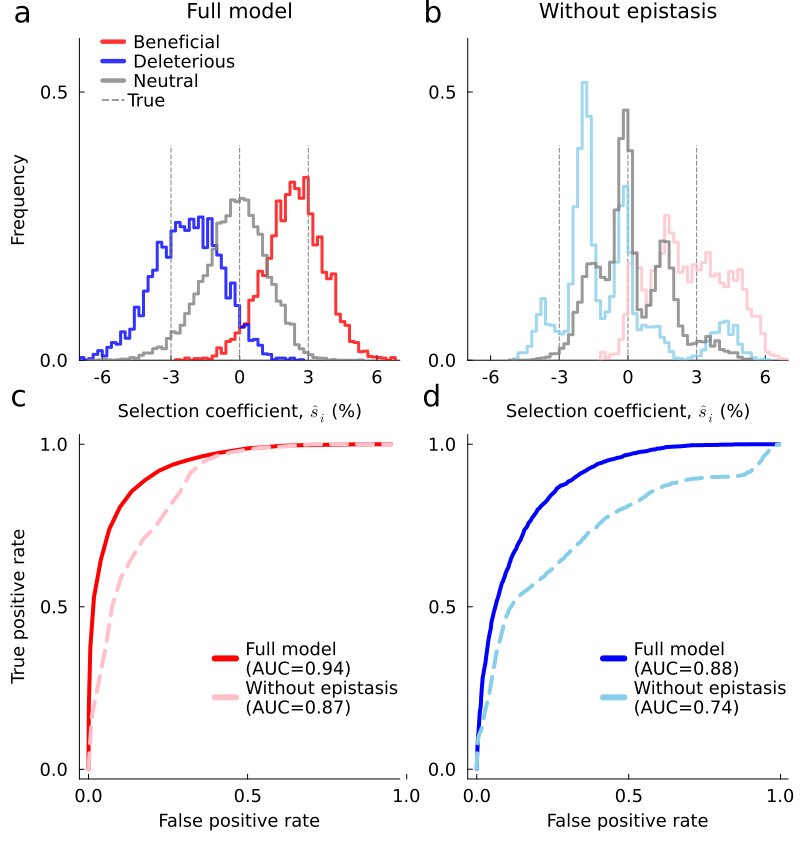

In [12]:

l = @layout [a{0.5w,0.483h} b{0.5w,0.483h}; 
             c{0.5w,0.517h} d{0.5w,0.517h}]
ptemp = Plots.plot(p1_selection_with_E, p1_selection_without_E, p2_selection_pos, p2_selection_neg, 
    layout=l, size=(800, 850), bottom_margin=2mm)
display(ptemp)
#Plots.savefig("../figures/selection_with_without_epistasis.pdf");

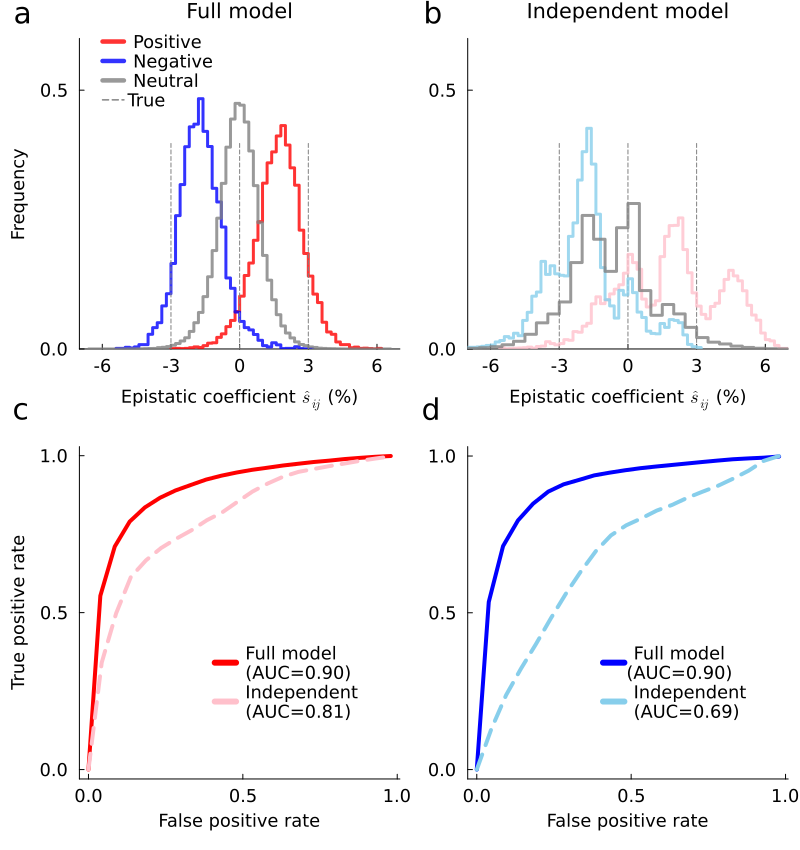

In [13]:
#Plots.plot(p1_epistasis_MPL, p1_epistasis_SL, layout=(1,2), size=(800, 350), bottom_margin=5mm)

l = @layout [a{0.5w,0.483h} b{0.5w,0.483h}; 
             c{0.5w,0.517h} d{0.5w,0.517h}]
ptemp = Plots.plot(p1_epistasis_MPL, p1_epistasis_SL, p2_epistasis_pos, p2_epistasis_neg, 
    layout=l, size=(800, 850), bottom_margin=2mm)
display(ptemp);
#Plots.savefig("../figures/Epistasis_with_without_linkage.pdf")

## Fig. S1 -- Effect of replicating statistics 

In [14]:
auc_add_with_E_pos_set, auc_add_with_E_neg_set = [], []
auc_epis_MPL_pos_set, auc_epis_MPL_neg_set = [], []
n_rep_set = [1, 3, 5, 10]
for n_rep_max in n_rep_set
    df_add_tot = CSV.read(@sprintf("../data/WF/replicated_rep-%d_selection.csv", n_rep_max), DataFrame)
    df_est_tot = CSV.read(@sprintf("../data/WF/replicated_rep-%d_epistasis.csv", n_rep_max), DataFrame)
    
    idx_sel_pos, idx_sel_neg, idx_sel_neu = df_add_tot.s_true .> 0, df_add_tot.s_true .< 0, df_add_tot.s_true .== 0;
    idx_eps_pos, idx_eps_neg, idx_eps_neu = df_est_tot.s_true .> 0, df_est_tot.s_true .< 0, df_est_tot.s_true .== 0;
    
    # ============= Beneficial mutation ============ #
    # --- Set accumulated TP and FP --- 
    idx_sort_add_with_E = sortperm(df_add_tot.s_MPL, rev=true)
    idx_sort_epis_MPL = sortperm(df_est_tot.s_MPL, rev=true)
    # --- Get TP and FP --- 
    (TP_add_with_E_pos, FP_add_with_E_pos) = get_TP_FP(idx_sel_pos, idx_sort_add_with_E)
    (TP_epis_MPL_pos, FP_epis_MPL_pos) = get_TP_FP(idx_eps_pos, idx_sort_epis_MPL)
    # --- Get AUC value. --- 
    auc_add_with_E_pos = get_ROC_AUC(TP_add_with_E_pos, FP_add_with_E_pos)
    auc_epis_MPL_pos = get_ROC_AUC(TP_epis_MPL_pos, FP_epis_MPL_pos)
    
    # ============= Deleterious mutation ============ #
    # --- Set accumulated TP and FP --- 
    idx_sort_add_with_E = sortperm(df_add_tot.s_MPL, rev=false)
    idx_sort_epis_MPL = sortperm(df_est_tot.s_MPL, rev=false)
    # --- Get TP and FP --- 
    (TP_add_with_E_neg, FP_add_with_E_neg) = get_TP_FP(idx_sel_neg, idx_sort_add_with_E)
    (TP_epis_MPL_neg, FP_epis_MPL_neg) = get_TP_FP(idx_eps_neg, idx_sort_epis_MPL)
    # --- Get AUC value. --- 
    auc_add_with_E_neg = get_ROC_AUC(TP_add_with_E_neg, FP_add_with_E_neg)
    auc_epis_MPL_neg = get_ROC_AUC(TP_epis_MPL_neg, FP_epis_MPL_neg);
    
    push!(auc_add_with_E_pos_set, auc_add_with_E_pos)
    push!(auc_add_with_E_neg_set, auc_add_with_E_neg)
    push!(auc_epis_MPL_pos_set, auc_epis_MPL_pos)
    push!(auc_epis_MPL_neg_set, auc_epis_MPL_neg);
end;

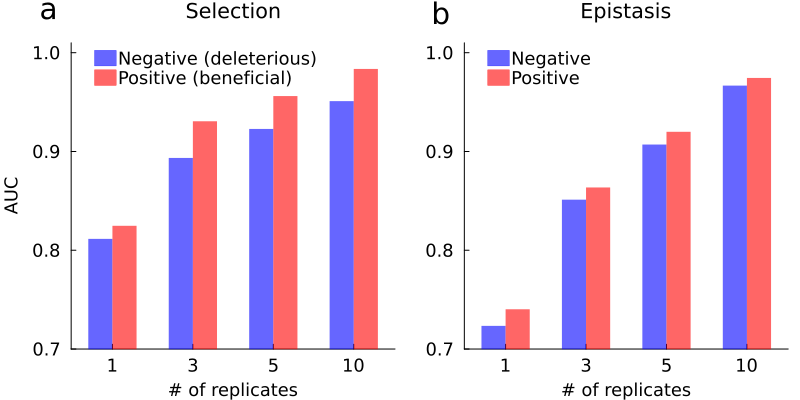

In [15]:

del_neg = repeat(["Negative (deleterious)"; "Positive (beneficial)"], inner = 4)
#xname = repeat([x for x in n_rep_set], outer = 2)
vec_grouped = Float64.([auc_add_with_E_neg_set; auc_add_with_E_pos_set])
p1 = groupedbar(vec_grouped, group=del_neg, ylabel = "AUC", title = "Selection", ylim=(0.7, 1.01), 
    lw=0, c = [:blue :red], bar_width=0.6, alpha=0.6, lc= [:blue :red],
    xticks=(collect(1:4), [x for x in n_rep_set]), xlabel="# of replicates")
annotate!(0.2, 1.045, text("a", :center, :black, 20) )

del_neg = repeat(["Negative"; "Positive"], inner = 4)
#xname = repeat([x for x in n_rep_set], outer = 2)
vec_grouped = Float64.([auc_epis_MPL_neg_set; auc_epis_MPL_pos_set])
p2 = groupedbar(vec_grouped, group=del_neg, title = "Epistasis", ylim=(0.7, 1.01), 
    lw=0, c = [:blue :red], bar_width=0.6, alpha=0.6, lc= [:blue :red],
    xticks=(collect(1:4), [x for x in n_rep_set]), xlabel="# of replicates")
annotate!(0.2, 1.04, text("b", :center, :black, 20) )
ptemp = Plots.plot(p1, p2, layout=(1,2), size=(800, 400), left_margin=3mm, bottom_margin=3mm, top_margin=5mm, legend=(0.15, 0.95))
display(ptemp);

#Plots.savefig("../figures/auc_replicated.pdf");